# Attitude tracking control on SO(3)

This is developed as a final project for BYU's ECEN774 Nonlinear Systems course.
It follows the control derivations by Taeyoung Lee in [Global Exponential Attitude Tracking Controls on SO(3)](https://arxiv.org/abs/1209.2926).


In [55]:
using OrdinaryDiffEq
import LinearAlgebra
LA = LinearAlgebra
using Plots
using LaTeXStrings
Plots.scalefontsizes(1.5)

## Super brief Lie theory for SO(3)
* Rotation matrices are members of the Lie group $\mathsf{SO(3)} = \{R \in \mathbb{R}^{3\times3} | R^T R = I, \mathrm{det}[R] = 1\}$. That is, the set of orthogonal $3\times3$ matrices with determinant 1.
* Every Lie Group has an associated Lie algebra which is the tangent space at the identity element. Derivatives or perturbations of members of a Lie group occur in the Lie algebra. For rotation matrices, the identity element is the identity matrix, $I$, and the Lie algebra is $\mathfrak{so}(3)$, the set of skew-symmetric matrices. The Lie algebra is isomorphic to $\mathbb{R}^3$, and the mapping is $(\cdot)^\wedge : \mathbb{R}^3 \to \mathfrak{so}(3)$. Note that this mapping corresponds to that of the cross operator $[\cdot]_\times$. 
* The exponential map $\mathrm{exp}: \mathfrak{so}(3) \to \mathsf{SO(3)}$ can be used to find the effect of perturbations on a rotation matrix. A common notational shortcut to use for finding the difference between elements in a group or incrementing an elemeent in a group. 

In [159]:
lie_eps = 1e-8 # used to check functions for places with numerical problems

function crossMat(w)
    """
    computes the skew-symmetric matrix from a 3-vector
    """
    wx = [0.0 -w[3] w[2]; w[3] 0.0 -w[1]; -w[2] w[1] 0.0]
    return wx
end

function hat(tau)
    """
    Computes the hat map, which maps from R^3 -> so(3)
    """
    return crossMat(tau)
end 

function vee(taux)
    """
    Computes the vee map, which maps from so(3) -> R^3
    """
    tau = [taux[3,2], taux[1, 3], taux[2,1]]
    return tau
end 

function expSO3(wx)
    """
    Computes the exponential map, which maps from so(3) -> SO(3)
    see Jackson's Transformations for Dummies for an explanation of the math
    """
    # find the angle/axis representation
    w = vee(wx)
    
    theta = sqrt(w'*w) # ||w||
    
    if (theta > 0.0 + lie_eps)
        # use large-angle (Rodriguez formula)
        R = LA.I + wx*(sin(theta)/theta) + wx*wx*((1-cos(theta))/theta^2)
    else
        # use small-angle (Taylor expansion)
        R = LA.I + wx*(1 - theta^2/6 + theta^4/120 ) + wx*wx*(1/2 - theta^2/24 + theta^4/720)
    end
    return R
end

function logSO3(R)
    """
    Computes the logarithmic map, which maps from SO(3) -> so(3)
    see Jackson's Transformations for Dummies for an explanation of the math
    """
    
    #### TODO ####
    temp = (LA.tr(R) - 1.0)/2.0
    if temp > 1.0
        temp = 1.0
    elseif temp < 0.0
        temp = 0.0
    end
    
    theta = acos(temp)
    
    if (theta > 0+ lie_eps && theta < pi/2 - lie_eps)
        # use large-angle
        logR = (theta/(2*sin(theta)))*(R-R')
    else
        # use small angle (Taylor Series)
        logR = (1.0/2.0)*(1+(1/6)*theta^2 + (7/360)*theta^4)*(R-R')
    end
    
    return logR
end

function rot2euler(R)
    """
    Convert a rotation matrix to euler angles for plotting
    """
    if abs(R[3,1]) <= (1.0 - lie_eps) # R31 != 1.0
        theta = -asin(R[3,1])
        ctheta = cos(theta)
        psi = atan(R[3,2]/ctheta, R[3,3]/ctheta)
        phi = atan(R[2,1]/ctheta, R[1,1]/ctheta)
    else
        phi = 0
        if R[3,1] < 0
            theta = pi/2
            psi = phi + atan(R[1,2], R[1,3])
        else
            theta = -pi/2
            psi = -phi + atan(-R[1,2], -R[1,3])
        end
    end
    
    return phi, theta, psi # roll, pitch, yaw
end    
   
function test1()
    w = [1., 2., 3.]
    
    wx = hat(w)
    println("wx = ", wx + wx')
    
    Rw = expSO3(wx)
    
    println("Rw = ", Rw - exp(wx))
end


test1()

wx = [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]
Rw = [0.0 0.0 -2.7755575615628914e-17; 2.7755575615628914e-17 -1.1102230246251565e-16 2.220446049250313e-16; 0.0 0.0 -5.551115123125783e-17]


Because of numerical error, the rotation matrix will slowly diverge from being orthogonal, which means that it will no longer be in $\mathsf{SO(3)}$ and it is no longer a valid rotation. This is true for any representation of rotation, and must be corrected. For a rotation matrix, the columns of the matrix must be normalized.

I tried three different methods of normalizing a rotation matrix. To compare between the methods, I used two different metrics, $\mathrm{tr}(R^TR) - 3$, which allows me to see how far off from orthogonal the rotation matrix is, and $\|\log(R_n^T R)^\wedge\|$, where $R_n$ is the normalization of $R$. This method allowed me to see "how close" the rotations were to each other. I also used the Euler-angle representation of the rotation matrix to examine the effect of the different normalizations.

1. Using the singular value decomposition:
\begin{align}
U, \Sigma, V^T = \mathrm{SVD}(R)\\
R_n = U V^T
\end{align}
```
U, S, Vt = LA.svd(R_kp1)
R_kp1 = U*Vt
```
This did produce an orthogonal matrix, but it caused large jumps (up to 1.5) in $\|\log(R_n^T R)^\wedge\|$.

2. Using the QR decomposition
\begin{align}
Q, U = \mathrm{QR}(R)\\
R_n = Q
\end{align}
```       
Q, _ = LA.qr(R_kp1)
R_kp1 = Q
```
This also produced an orthogonal matrix, and $\|\log(R_n^T R)^\wedge\| < 1\times 10^{-4}$, however the euler angles produced by the rotation were hard to interpret and had additional discontinuities.

3. Using the Gram-Schmidt orthogonalization on the columns of R. This isn't implemented in a Julia library, so I wrote my own super simple implementation that will only work for $3\times3$ matrices.
\begin{align}
R_n = \mathrm{GramSchmidt}(R)
\end{align}
```
R_kp1 = gramSchmidt(R_kp1)
```
This produced the best results, with the error $\|\log(R_n^T R)^\wedge\| < 1\times 10^{-4}$ and the euler angles looking the same as they did without orthogonalization, having discontinuities only at $\pm \pi$. 

In [160]:

function gramSchmidt(R)
    """
    Orthonormalize a 3x3 matrix
    """
    p1 = R[:,1]
    p2 = R[:,2]
    p3 = R[:,3]

    q1 = p1/LA.norm(p1)
    e2 = p2 - (p2'*q1)*q1
    q2 = e2/LA.norm(e2)
    e3 = p3 - (p3'*q1)*q1 - (p3'*q2)*q2
    q3 = e3/LA.norm(e3)
    
    return hcat(q1, q2, q3)
end
    

gramSchmidt (generic function with 1 method)

## Dynamics
We are studying the attitude dynamics of a 3 dimensional rigid body, given by
\begin{align}
\dot{\Omega} &= - J^{-1} \Omega_\times J \Omega + J^{-1} u + J^{-1} \Delta \\
\dot{R} &= R \Omega^\wedge
\end{align}
where $\Omega \in \mathbb{R}^3$ is the angular rate of the body, represented in the body frame, $J \in \mathbb{R}^{3\times3}$ is the inertia matrix, $u \in \mathbb{R}^3$ is the applied control moment, $\Delta \in \mathbb{R}^3$ is a fixed uncertainty, assumed to be bounded (i.e. $\| \Delta \| \leq B_\Delta \in \mathbb{R}$), and $R \in \mathsf{SO(3)}$ is a rotation matrix from a body-fixed frame to an inertial frame.

The states $\Omega$ and $R$ of this system can be represented as the tuple $x \in \mathbb{R}^3 \times \mathsf{SO}(3) = (\Omega, R)$. This yields the convenient notation
\begin{align}
\dot{x} = f(x, u).
\end{align}

The system we are considering is a rectangular prism 3 units long, 2 units wide and 1 unit deep.


In [61]:
J = LA.Diagonal([1., 2., 3.])
Delta = .1*ones(3)

3-element Array{Float64,1}:
 0.1
 0.1
 0.1

In [39]:
function attDynamics(Omega, R, u) 
    Omega_d = -J\(crossMat(Omega)*J*Omega + u + Delta)
    R_d = R*hat(Omega)
    return (Omega_d, R_d)
end    

attDynamics (generic function with 2 methods)

### Numerical Integration
The integration of $R$ must be done properly in order for the solution to remain on the manifold of $\mathsf{SO(3)}$. 
Assuming constant $\omega$ the solution to $\dot{R} = R \omega^\wedge$ is 
$$
R(t) = R(0) \mathrm{exp}(\omega^\wedge t).
$$ 

If instead, we let $\omega$ vary over time, we get the euler approximation,
$$
R_{k+1} \approx R_k \mathrm{exp}(\omega^\wedge \mathrm{Ts}) \triangleq R_k \oplus (\omega \mathrm{Ts})
$$

The $\oplus$ operator can be used to extend fourth order Runge-Kutta integration to $\mathsf{SO(3)}$.

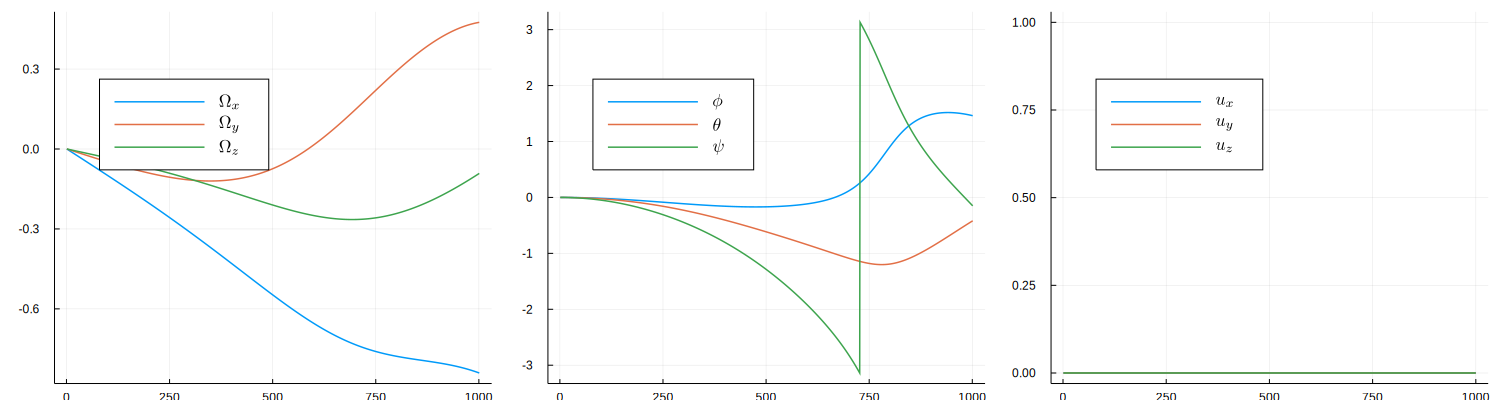


Progress: ##################################################

In [182]:

function propagateRK4(Omega_k, R_k, u_k; dt=0.01)
    """
    Propagate the attitude dynamics by one timestep using RK4 integration
    """
    
    Omega_F1, R_F1 = attDynamics(   Omega_k, 
                                    R_k, 
                                    u_k)
    Omega_F2, R_F2 = attDynamics(   Omega_k + Omega_F1*dt/2, 
                                    R_k*expSO3(R_F1*dt/2),
                                    u_k)
    Omega_F3, R_F3 = attDynamics(   Omega_k + Omega_F2*dt/2, 
                                    R_k*expSO3(R_F2*dt/2),
                                    u_k) 
    Omega_F4, R_F4 = attDynamics(   Omega_k + Omega_F3*dt, 
                                    R_k*expSO3(R_F3*dt),
                                    u_k) 
    
    Omega_kp1 = Omega_k + (dt/6)*(Omega_F1 + 2*Omega_F2 + 2*Omega_F3 + Omega_F4)
    R_kp1     = R_k     + (dt/6)*(R_F1     + 2*R_F2     + 2*R_F3     + R_F4)
    
    return (Omega_kp1, R_kp1)
end

function runDynamics(Omega0, R0, controller; dt=0.01, tf=10)
    """
    Run the dynamics and save R, Omega, and u
    """
    
    N = Int(tf/dt)
    
    Omega_vec = zeros(3,1,N+1)
    R_vec = zeros(3,3,N+1)
    R_no_ortho = zeros(3,3,N+1)
    u_vec = zeros(3,1,N)
    
    Omega_vec[:,:,1] = Omega0
    R_vec[:,:,1] = R0
    
    Omega_k = Omega0
    R_k = R0
    
    println("")
    print("Progress: ")
    
    for k in range(1, length=N)
        u_k = controller(Omega_k, R_k)
        Omega_kp1, R_kp1 = propagateRK4(Omega_k, R_k, u_k, dt=dt)
        
        # orthogonalize R        
        R_kp1 = gramSchmidt(R_kp1)
                
        Omega_vec[:,:,k+1] = Omega_kp1
        R_vec[:,:,k+1] = R_kp1
        u_vec[:,:,k] = u_k
        
        Omega_k = Omega_kp1
        R_k = R_kp1
        
        if k%(N/50) == 0
            # simple progress indicator, will print 50 times
            print("#")
        end
    end
    
    return Omega_vec, R_vec, u_vec
end

function testDynamics()
    
    function dumbControl(Omega, R)
        u = zeros(3)
        return u
    end
    
    R0 = Matrix{Float32}(LA.I, 3, 3)
    Omega0 = zeros(3)
    
    Omega_vec, R_vec, u_vec = runDynamics(Omega0, R0, dumbControl)
    
    return Omega_vec, R_vec, u_vec
end

function plotOmega(Omega_vec)
#     Omega_plot = plot(reuse=false)
    
    Omega_plot = plot(Omega_vec[:,1,:]', label=[L"$\Omega_x$" L"$\Omega_y$" L"$\Omega_z$"], legend=:topleft, linewidth=1.5)
    return Omega_plot
end

function plotR(R_vec)
    # convert R_vec to euler angles
    euler_vec = zeros(3, size(R_vec)[3])
    for k = 1:size(R_vec)[3]
        phi, theta, psi = rot2euler(R_vec[:,:,k])
        euler_vec[:,k] = [phi, theta, psi]
    end
    euler_plot = plot(euler_vec[:,:]', label=[L"\phi" L"\theta" L"\psi"], legend=:topleft, linewidth=1.5)
    return euler_plot
end

function plotU(u_vec)
    u_plot = plot(u_vec[:,1,:]', label=[L"u_x" L"u_y" L"u_z"], legend=:topleft, linewidth=1.5)
    return u_plot
end

function plotDynamics(Omega_vec, R_vec, u_vec)
    p_omega = plotOmega(Omega_vec)
    p_R = plotR(R_vec)
    p_u = plotU(u_vec)
    display(plot(p_omega, p_R, p_u, layout=(1,3), size=(3*500, 400)))
end

Omega_vec, R_vec, u_vec = testDynamics()
plotDynamics(Omega_vec, R_vec, u_vec)

## Control
X